In [84]:
#Importing the libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy import stats
from scipy.stats import t as t 
from scipy.optimize import curve_fit
from scipy.constants import *
from scipy.stats import poisson

from uncertainties import *
from uncertainties.umath import *

In [85]:
#Reading data

chi2 = pd.read_excel('data/f_n.xlsx')
F1 = pd.read_csv('data/F1.csv')
F2 = pd.read_csv('data/F2.csv')
F3 = pd.read_csv('data/F3.csv')
F4 = pd.read_csv('data/F4.csv')

In [86]:
# Constants and values

def uncert(data_input, uncert_inst):
    t_coeff = t.ppf((1 + 0.6827)/2, len(data_input)-1)
    return np.sqrt((np.std(data_input)/np.sqrt(len(data_input)))**2 + uncert_inst**2)*t_coeff

v = 2 #cm
d = 22.7 #cm
T = 1999 #s

In [87]:
chi2

,f,N,t
0,2,24,120
1,4,42,120
2,6,48,120
3,8,24,40
4,10,25,40
5,12,25,40
6,14,19,40
7,16,12,40
8,18,35,120
9,20,16,120


In [88]:
#Canculation

chi2['f'] = d - chi2['f']

chi2['r_1'] = np.sqrt(v**2 + (d - chi2['f'])**2)
chi2['r_2'] = np.sqrt(v**2 + chi2['f']**2)

chi2['alpha'] = np.rad2deg(np.arccos((d - chi2['f']) / chi2['r_1']))
chi2['beta'] = np.rad2deg(np.arccos(chi2['f'] / chi2['r_2']))

chi2['chi'] = chi2['alpha'] + chi2['beta']

chi2['x'] = (np.cos(np.deg2rad(chi2['alpha'])) * np.cos(np.deg2rad(chi2['beta']))) / (np.sin(np.deg2rad(chi2['chi']/2)**4) * chi2['r_1']**2 * chi2['r_2']**2)

chi2['n'] = chi2['N'] / (chi2['t'] / 60)

F1 = F1[["t", "U"]]
F2 = F2[["t", "U"]]
F3 = F3[["t", "U"]]
F4 = F4[["t", "U"]]

F2['t'] = F2['t'] + 499.8
F3['t'] = F3['t'] + 999.6
F4['t'] = F4['t'] + 1499.4

F_comb = pd.concat([F1, F2, F3, F4], ignore_index=True)

F_filtered = F_comb[F_comb['U'] >= 0.25] 
F_filtered.reset_index(drop=True, inplace=True)

In [89]:
start_t = F_filtered['t'][0]
end_t = F_filtered['t'].iloc[-1]
step = 60

t_val = np.arange(start_t, end_t, step)

N = len(t_val) - 1 
print(f'N = {N}')

N = 32


In [90]:
counts = []

for i in range(len(t_val)-1):
    lower_bound = t_val[i]
    upper_bound = t_val[i+1]
    
    count = ((F_filtered['t'] >= lower_bound) & (F_filtered['t'] <= upper_bound)).sum()

    counts.append(count)

print('counts:', len(counts))

lambda_fit = np.mean(counts)
print(f'lambda = {lambda_fit}')

counts: 32
lambda = 19.90625


In [91]:
NP = []
for i in range(N):
    res = lambda_fit**i / factorial(i) * np.exp(-lambda_fit) * N
    NP.append(res)

NP_list = [sum(NP[:14]), sum(NP[14:19]), sum(NP[19:21]), sum(NP[21:24]), sum(NP[24:32])]
print(f'NP = {NP_list}')

K = [0] * len(NP_list)
for i in counts:
    if i <= 14:
        K[0] += 1
    elif 14 < i <= 19:
        K[1] += 1
    elif 19 < i <= 21:
        K[2] += 1
    elif 21 < i <= 24:
        K[3] += 1
    elif 24 < i <= 32:
        K[4] += 1

print(f'K = {K}')

K_list = np.array(K)
NP_list = np.array(NP_list)

chi2_val = np.sum((K_list - NP_list)** 2 / NP_list)
print(f'chi2 = {chi2_val}')


NP = [2.1987767925534802, 10.2610799005916, 5.697592390370158, 7.2415445227266915, 6.357807985099139]
K = [5, 7, 5, 8, 7]
chi2 = 4.834856207416969


In [92]:
# Linear regression for n(x)

slope, intercept, r_value, p_value, std_err = stats.linregress(chi2['x'], chi2['n'])

K = ufloat(slope, std_err)
print('K =', K, 'min^-1 cm^4')

#Best fit line 
K_fit = slope * np.array(chi2['x']) + intercept

chi2['n_teor'] = K * (np.cos(np.deg2rad(chi2['alpha'])) * np.cos(np.deg2rad(chi2['beta']))) / (np.sin(np.deg2rad(chi2['chi']/2)**4) * chi2['r_1']**2 * chi2['r_2']**2)

K = (4.9+/-0.8)e+02 min^-1 cm^4


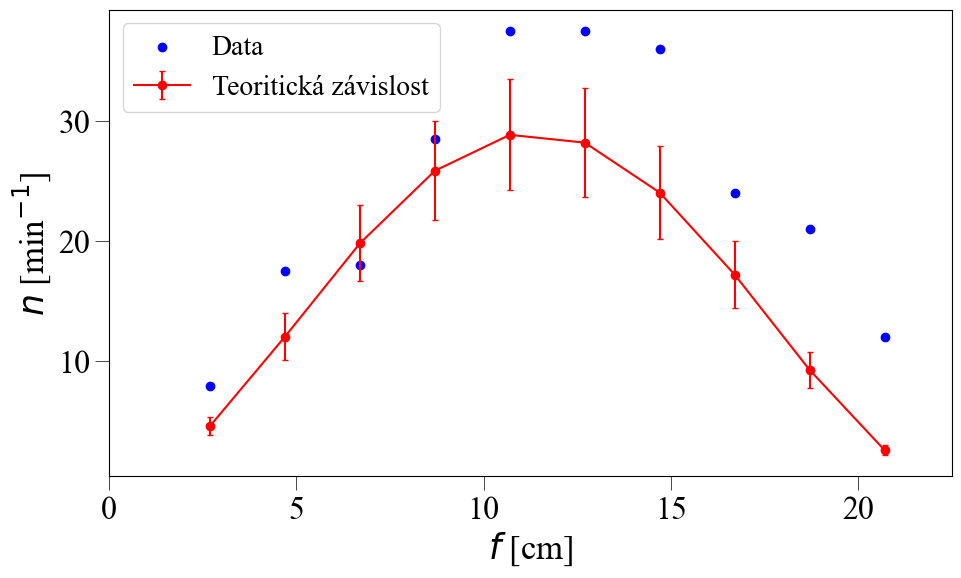

In [93]:
# Plot of dependence n(f)

colors = ['#FF7F0E','#D62728','#FFDB58','#2CA02C','#17BECF','#1F77B4','#F0027F']  
plt.rc("font", size=10)
plt.rcParams["font.family"] = "Times New Roman"

# Define the font size
ax_l_size = 25
l_size = 23

fig, ax = plt.subplots(figsize=(10, 6))

# ax.title.set_fontsize(ax_l_size)
ax.set_xlabel(r"$f$ [cm]")
ax.xaxis.label.set_fontsize(ax_l_size)
ax.set_ylabel(r"$n$ [min$^{-1}$]")
ax.yaxis.label.set_fontsize(ax_l_size)
ax.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=l_size)
ax.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=l_size)
# plt.xticks(rotation=45)
plt.tight_layout()  

ax.set_xlim(0, 22.5)

ax.scatter(chi2['f'], chi2['n'], color='blue', label='Data')
ax.errorbar(chi2['f'], chi2['n_teor'].apply(lambda x: x.nominal_value), yerr=chi2['n_teor'].apply(lambda x: x.std_dev), fmt='-o', capsize=2, color='red', label='Teoritická závislost')
ax.legend(loc='upper left', fontsize=20)

plt.show() 

fig.savefig('images/n(f).png', bbox_inches='tight')

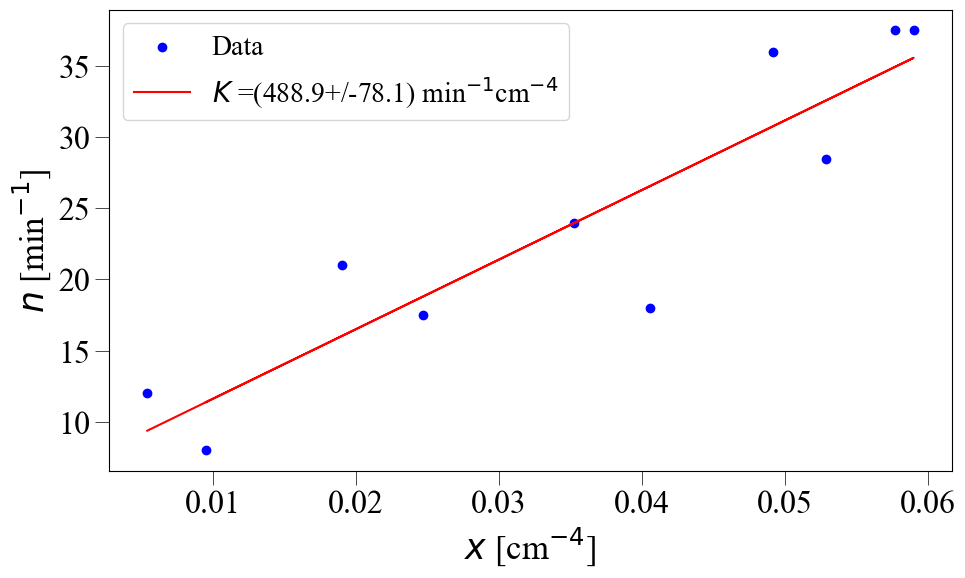

In [94]:
# Plot of dependence n(x)

fig, ax = plt.subplots(figsize=(10, 6))

# ax.title.set_fontsize(ax_l_size)
ax.set_xlabel(r"$x$ [cm$^{-4}$]")
ax.xaxis.label.set_fontsize(ax_l_size)
ax.set_ylabel(r"$n$ [min$^{-1}$]")
ax.yaxis.label.set_fontsize(ax_l_size)
ax.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=l_size)
ax.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=l_size)
# plt.xticks(rotation=45)
plt.tight_layout()  

ax.scatter(chi2['x'], chi2['n'], color='blue', label='Data')
ax.plot(chi2['x'], K_fit, color='red', label=r'$K$ =' + f'({K:.1f})' + r' min$^{-1}$cm$^{-4}$')

ax.legend(loc='upper left', fontsize=20)

plt.show() 

fig.savefig('images/n(x).png', bbox_inches='tight')

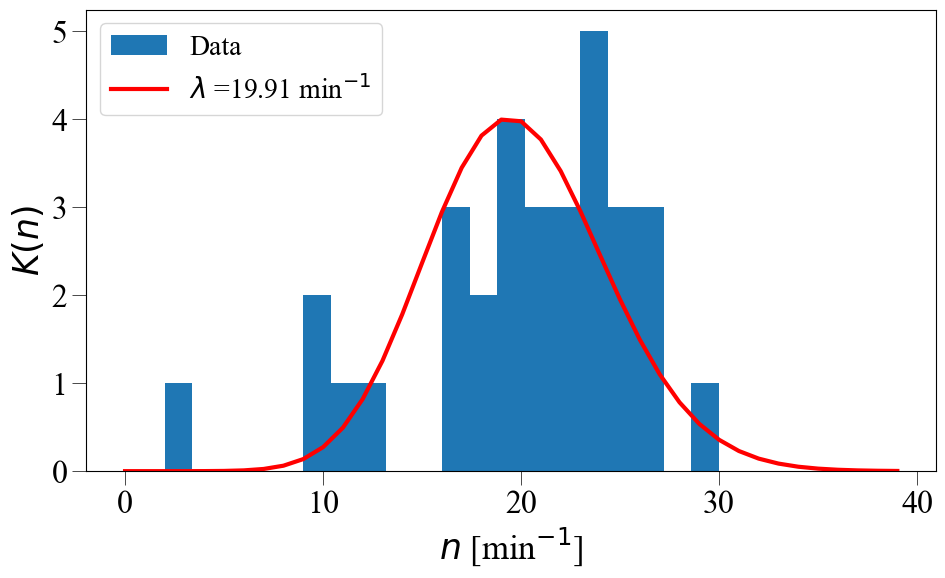

In [95]:
# Plot histogram K(n)

fig, ax = plt.subplots(figsize=(10, 6))

# ax.title.set_fontsize(ax_l_size)
ax.set_xlabel(r"$n$ [min$^{-1}$]")
ax.xaxis.label.set_fontsize(ax_l_size)
ax.set_ylabel(r"$K(n)$")
ax.yaxis.label.set_fontsize(ax_l_size)
ax.tick_params(axis="both", which="major", length=10, width=0.5, labelsize=l_size)
ax.tick_params(axis="both", which="minor", length=5, width=0.5, labelsize=l_size)
# plt.xticks(rotation=45)
plt.tight_layout()  


hist, bins, _ = ax.hist(counts, bins=20, density=False, label='Data')

x = np.arange(0, max(counts)+10)

bin_width = bins[1] - bins[0]
total_counts = len(counts)

y_fit = poisson.pmf(x, lambda_fit) * total_counts * bin_width

ax.plot(x, y_fit, color='red', linewidth=3, label=r'$\lambda$ =' + f'{lambda_fit:.2f}' + r' min$^{-1}$')

ax.legend(loc='upper left', fontsize=20)

plt.show() 

fig.savefig('images/K(n).png', bbox_inches='tight')

In [96]:
chi2

,f,N,t,r_1,r_2,alpha,beta,chi,x,n,n_teor
0,20.7,24,120,2.828427,20.796394,45.000000,5.518694,50.518694,0.005386,12.0,2.6+/-0.4
1,18.7,42,120,4.472136,18.806648,26.565051,6.104685,32.669736,0.019031,21.0,9.3+/-1.5
2,16.7,48,120,6.324555,16.819334,18.434949,6.829244,25.264193,0.035232,24.0,17.2+/-2.8
3,14.7,24,40,8.246211,14.835431,14.036243,7.747772,21.784016,0.049182,36.0,24+/-4
4,12.7,25,40,10.198039,12.856516,11.309932,8.949458,20.259391,0.057675,37.5,28+/-5
5,10.7,25,40,12.165525,10.885311,9.462322,10.587321,20.049644,0.058998,37.5,29+/-5
6,8.7,19,40,14.142136,8.926926,8.130102,12.946510,21.076612,0.052894,28.5,26+/-4
7,6.7,12,40,16.124515,6.992138,7.125016,16.620757,23.745773,0.040567,18.0,19.8+/-3.2
8,4.7,35,120,18.110770,5.107837,6.340192,23.051301,29.391493,0.024693,17.5,12.1+/-1.9
9,2.7,16,120,20.099751,3.360060,5.710593,36.528855,42.239449,0.009496,8.0,4.6+/-0.7


In [97]:
intervals = ['(0, 14]', '(14, 19]', '(19, 21]', '(21, 24]', '(24, 32]']
poiss = pd.DataFrame({'n': intervals, 'K': K_list, 'NP': NP_list})

In [98]:
poiss

,n,K,NP
0,"(0, 14]",5,2.198777
1,"(14, 19]",7,10.261080
2,"(19, 21]",5,5.697592
3,"(21, 24]",8,7.241545
4,"(24, 32]",7,6.357808


In [99]:
chi2 = chi2.round(2)
poiss = poiss.round(2)

chi2.to_csv('data/chi2_out.csv', index=False)
# poiss.to_csv('data/poiss_out.csv', index=False)